In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [17]:
import pandas as pd
import numpy as np
from statsmodels.graphics import tsaplots
from statsmodels.stats import diagnostic
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import scipy

from load_dataset import Dataset
import plotting

In [18]:
dataset = Dataset('../data/dataset/')

In [19]:
# Возьмем временной ряд.

In [20]:
ts = dataset['international-airline-passengers.csv']

In [21]:
# нарисуем. Видим ярко выраженную сезонность (мб не одну?), гетероскедастичность и тренд.

<AxesSubplot:xlabel='1949-01'>

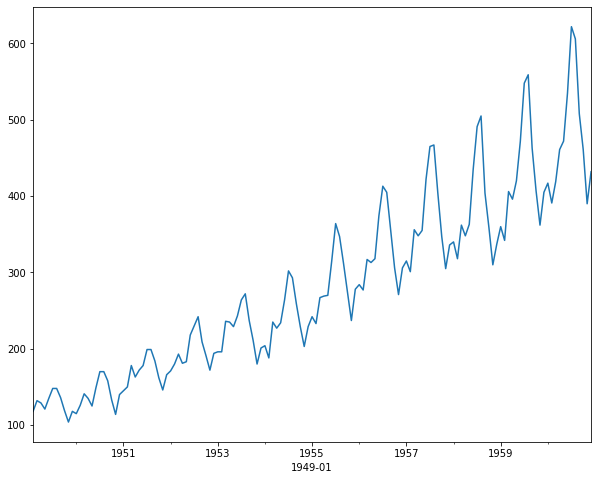

In [22]:
ts.plot(figsize=(10, 8))

In [23]:
# Посммотрим график автокорреляций - видим тренд и сильную цикличную автокореляцию

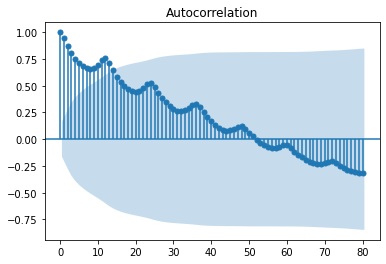

In [24]:
tsaplots.plot_acf(ts, lags=80);

In [25]:
# проверим автокорреляция при помощи теса Ланга-Бокса

In [26]:
_, p_value = diagnostic.acorr_ljungbox(ts)

/Users/g.sinyakov/ts_autumn/.env/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "
/Users/g.sinyakov/ts_autumn/.env/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [27]:
# видим, что значения p-value сильно ниже порога (обычно 0.05, 0.01), значит мы смело отвергаем нулевую гипотезу
# то есть данные явно не случайны
max(p_value), min(p_value)

(2.2652961479646928e-30, 0.0)

In [28]:
# проверим ряд на стационарость критерием Дики-Фуллера
# видим, что p-value сильно выше порога, значит мы никак не можем отвергнуть нулевую гипотезу, следовательно -
# ряд не стационарен
p_value = adfuller(ts)[1]
p_value

0.9915115096288659

In [29]:
# Попробуем сделать его стационарным
# Для начала постараемся избавиться от гетероскедастичности, взяв логарифм
ts_log = np.log(ts)

<AxesSubplot:xlabel='1949-01'>

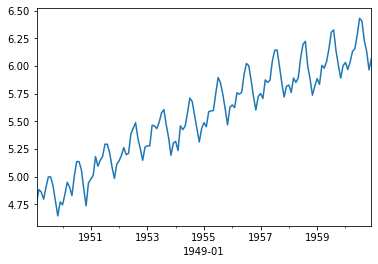

In [30]:
ts_log.plot()
# отлично, на вид, гетероскедастичность ушла

In [31]:
# впрочем, наши статистические тесты остались этим неудовлетворены и снова показывают крайнюю нестационарность
# скоррелированность
_, p_value = diagnostic.acorr_ljungbox(ts_log)
print(min(p_value), max(p_value))
print(adfuller(ts)[1])

0.0 9.436327894354704e-31
0.9915115096288659


/Users/g.sinyakov/ts_autumn/.env/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "
/Users/g.sinyakov/ts_autumn/.env/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [32]:
# чтож, попробуем применить дифференцирование
ts_diff = ts_log.diff()

In [36]:
plotting.plot_ts(ts_log, ts_diff)

Loading BokehJS ...

In [37]:
_, p_value = diagnostic.acorr_ljungbox(ts_diff.dropna(), lags=70)
print(min(p_value), max(p_value))
print(adfuller(ts_diff.dropna())[1])

4.0377134029604414e-107 0.02104816426436633
0.048033972528752085


/Users/g.sinyakov/ts_autumn/.env/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='1949-01'>

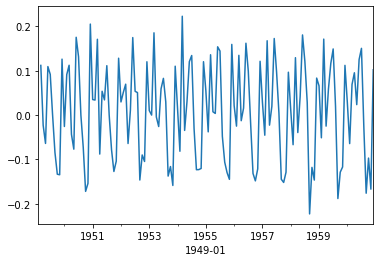

In [38]:
ts_diff.plot()

In [39]:
# кхмм, опять не помогает, давайте посмотрим на график автокорреляций и увидим, что период сезонности 
# приходится на 12 лаг, попробуем сезонное дифференцирование

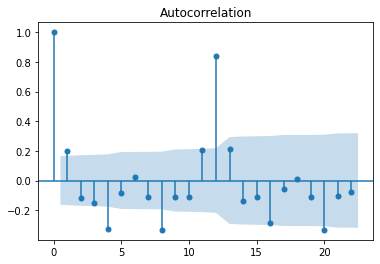

In [40]:
tsaplots.plot_acf(ts_diff.dropna());

In [41]:
ts_season_diff = ts_diff.diff(12)

In [42]:
_, p_value = diagnostic.acorr_ljungbox(ts_season_diff.dropna(), lags=45)
print(min(p_value), max(p_value))
print(adfuller(ts_season_diff.dropna())[1])

6.188062493682463e-07 0.0025904863525081454
0.00016009049261960388


/Users/g.sinyakov/ts_autumn/.env/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='1949-01'>

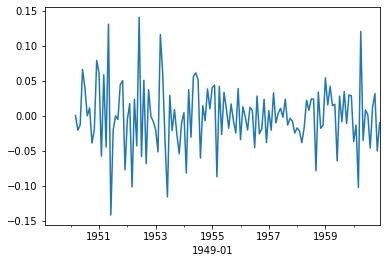

In [43]:
ts_season_diff.plot()

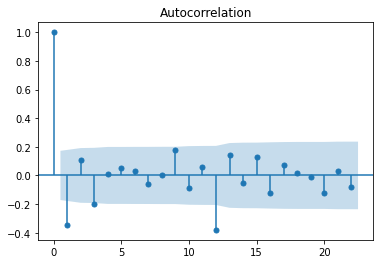

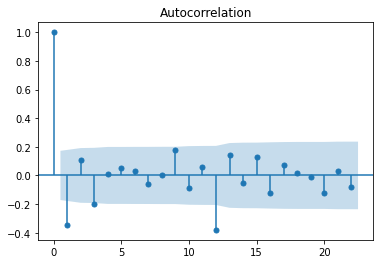

In [44]:
tsaplots.plot_acf(ts_season_diff.dropna())

In [45]:
# Бонус - пример простого обратно трансформирования ряда. По сути, к ряду просто применяются обратные операторы.
# exp для log, кумулятивная сумма для дифференцирования

In [46]:
ts = dataset['hour_3553.csv']

<AxesSubplot:xlabel='2019-05-19T03:00:00'>

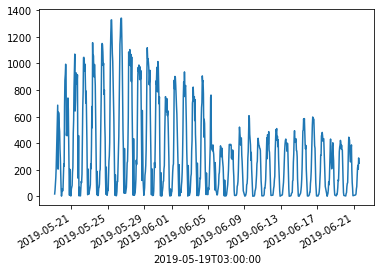

In [47]:
ts.plot()

In [48]:
transformed = np.log(ts).diff()

<AxesSubplot:xlabel='2019-05-19T03:00:00'>

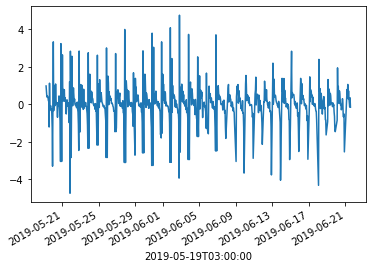

In [49]:
transformed.plot()

In [50]:
back_transformed = np.exp(transformed.cumsum())

<AxesSubplot:xlabel='2019-05-19T03:00:00'>

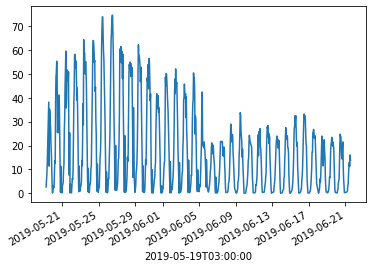

In [51]:
back_transformed.plot()

## Задание:
    1. Выбрать ряд stl_example.csv.
    2. Используя вышеперечисленные преобразования, добиться стационарности ряда.
    3. Критерием стационарности будет служить значение p-value теста Дики-Фуллера, меньшее 0.05 и соответствующий график автокорреляции.